# Final Project Submission

* Students names: Cody Freese/Fennec Nightingale/Thomas Cornett
* Student pace: Part time
* Instructor name: Amber Yandow
* Blog post URL:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>

<font size=3rem>
    
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
</font>
___

# INTRODUCTION

# OBTAIN

## Import tools

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import zscore
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## King County dataset

In [3]:
# read data
kc_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 
              'sqft_basement', 'yr_built']

kc_dtypes = {'id': int, 'date' : str,  'price': float, 'bedrooms' : int, 'bathrooms' : float, 'sqft_living': int, 'sqft_lot': int, 
             'floors': float, 'waterfront': float, 'view' : float, 'condition': float, 'grade': int, 'sqft_above': int, 
             'yr_built': int, 'yr_renovated': float, 'zipcode': float, 'lat': float, 'long': float}

kc_data = pd.read_csv('kc_house_data.csv', dtype = kc_dtypes, parse_dates = ['date'])

kc_data['sqft_basement'] = kc_data['sqft_basement'].replace({'?': 0})
kc_data['sqft_basement'] = kc_data['sqft_basement'].astype(dtype=float, errors='ignore')

In [4]:
#drop unnessecary columns and fix data
kc_data = kc_data.drop('sqft_living15', 1).drop('sqft_lot15', 1)

#look for outliers, in bedrooms, we can clearly see a single outlier, for other columns, filtering by z score will be easiest 
kc_data[kc_data['bedrooms'] == 33]
# wouldn't be realistic for a house with 33 bedrooms to only have a sqft_living of 1620 and only 1 3/4 bathrooms so it looks like a typo
# will adjust to 3 
kc_data[kc_data['bedrooms'] == 33] = kc_data[kc_data['bedrooms'] == 33].replace(33,3)

In [5]:
#setting waterfront NaN values equal to the ratio of waterfront/non-waterfront properties, will want to try and narrow by zipcode 
#filling NaN with easily seperatable/changable values helpful 
kc_data['waterfront'] = kc_data['waterfront'].fillna(146/19221)
kc_data['view'] = kc_data['view'].fillna((957 + (508*2) + (330*3) + (317*4))/21534)
kc_data['yr_renovated'] = kc_data['yr_renovated'].fillna(0)

In [6]:
#Convert to integer for whole number year
kc_data['yr_renovated'] = kc_data['yr_renovated'].astype('int')

# SCRUB

## Dataframe Info

In [7]:
kc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
id               21597 non-null int32
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int32
bathrooms        21597 non-null float64
sqft_living      21597 non-null int32
sqft_lot         21597 non-null int32
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null float64
grade            21597 non-null int32
sqft_above       21597 non-null int32
sqft_basement    21597 non-null float64
yr_built         21597 non-null int32
yr_renovated     21597 non-null int32
zipcode          21597 non-null float64
lat              21597 non-null float64
long             21597 non-null float64
dtypes: datetime64[ns](1), float64(10), int32(8)
memory usage: 2.5 MB


## Check for NaN

In [8]:
kc_data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
dtype: int64

## Drop Null Values

In [9]:
#Drop NaN
kc_data = kc_data.copy()
df_renovated = kc_data
df_renovated

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,-1460634072,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.007596,0.0,3.0,7,1180,0.0,1955,0,98178.0,47.5112,-122.257
1,2119132896,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.000000,0.0,3.0,7,2170,400.0,1951,1991,98125.0,47.7210,-122.319
2,1336533104,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.000000,0.0,3.0,6,770,0.0,1933,0,98028.0,47.7379,-122.233
3,-1807766421,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.000000,0.0,5.0,7,1050,910.0,1965,0,98136.0,47.5208,-122.393
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.000000,0.0,3.0,8,1680,0.0,1987,0,98074.0,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.000000,0.0,3.0,8,1530,0.0,2009,0,98103.0,47.6993,-122.346
21593,-1989874472,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.000000,0.0,3.0,8,2310,0.0,2014,0,98146.0,47.5107,-122.362
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.000000,0.0,3.0,7,1020,0.0,2009,0,98144.0,47.5944,-122.299
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0.007596,0.0,3.0,8,1600,0.0,2004,0,98027.0,47.5345,-122.069


## Convert Year Renovated to Integer

In [10]:
#Ensuring no strings in yr_renovated
#df_renovated['yr_renovated'] = df_renovated['yr_renovated'].astype('float')
#Convert to integer for whole number year
#df_renovated['yr_renovated'] = df_renovated['yr_renovated'].astype('int')
#Convert Zipcode to Float
#df_renovated['zipcode'] = df_renovated['zipcode'].astype('float')
#Convert Condition to float
#df_renovated['condition'] = df_renovated['condition'].astype('float')

## Renovated Info

In [11]:
df_renovated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
id               21597 non-null int32
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int32
bathrooms        21597 non-null float64
sqft_living      21597 non-null int32
sqft_lot         21597 non-null int32
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null float64
grade            21597 non-null int32
sqft_above       21597 non-null int32
sqft_basement    21597 non-null float64
yr_built         21597 non-null int32
yr_renovated     21597 non-null int32
zipcode          21597 non-null float64
lat              21597 non-null float64
long             21597 non-null float64
dtypes: datetime64[ns](1), float64(10), int32(8)
memory usage: 2.5 MB


## Datetime

In [12]:
#df_renovated['date'] = pd.to_datetime(df_renovated['date'])
#df_renovated['date']

## For Loop - Value Counts

In [13]:
for col in df_renovated.columns:
    try:
        print(col, df_renovated[col].value_counts()[:5])
    except:
        print(col, df_renovated[col].value_counts())
    print('\n')

id  795000620     3
-1202434357    2
 1545800290    2
-2063467266    2
 723049156     2
Name: id, dtype: int64


date 2014-06-23    142
2014-06-25    131
2014-06-26    131
2014-07-08    127
2015-04-27    126
Name: date, dtype: int64


price 350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64


bedrooms 3    9825
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64


bathrooms 2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
Name: bathrooms, dtype: int64


sqft_living 1300    138
1400    135
1440    133
1660    129
1010    129
Name: sqft_living, dtype: int64


sqft_lot 5000    358
6000    290
4000    251
7200    220
7500    119
Name: sqft_lo

## Check for duplicates

In [14]:
duplicates = df_renovated[df_renovated.duplicated()]
print(len(duplicates))
duplicates.head()

0


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long


## Value Counts

In [15]:
# Value counts for variables
for col in df_renovated.columns:
    print(col, '\n', df_renovated[col].value_counts(normalize=True).head(), '\n\n')

id 
  795000620     0.000139
-1202434357    0.000093
 1545800290    0.000093
-2063467266    0.000093
 723049156     0.000093
Name: id, dtype: float64 


date 
 2014-06-23    0.006575
2014-06-25    0.006066
2014-06-26    0.006066
2014-07-08    0.005880
2015-04-27    0.005834
Name: date, dtype: float64 


price 
 350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
Name: price, dtype: float64 


bedrooms 
 3    0.454924
4    0.318655
2    0.127796
5    0.074131
6    0.012594
Name: bedrooms, dtype: float64 


bathrooms 
 2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
Name: bathrooms, dtype: float64 


sqft_living 
 1300    0.006390
1400    0.006251
1440    0.006158
1660    0.005973
1010    0.005973
Name: sqft_living, dtype: float64 


sqft_lot 
 5000    0.016576
6000    0.013428
4000    0.011622
7200    0.010187
7500    0.005510
Name: sqft_lot, dtype: float64 


floors 
 1.0    0.494189
2.0    0.3813

## Function on Variables

In [16]:
def check_column(df_renovated, col_name, n_unique=10):
    print('Datatype')
    print('\t',df_renovated[col_name].dtypes)
    
    num_nulls = df_renovated[col_name].isna().sum()
    print(f'Null Values Present = {num_nulls}')
    
    display(df_renovated[col_name].describe().round(3))
    
    print('\nValue Counts:')
    display(df_renovated[col_name].value_counts(n_unique))
    
check_column(df_renovated,'price')

Datatype
	 float64
Null Values Present = 0


count      21597.000
mean      540296.574
std       367368.140
min        78000.000
25%       322000.000
50%       450000.000
75%       645000.000
max      7700000.000
Name: price, dtype: float64


Value Counts:


350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
              ...   
870515.0    0.000046
336950.0    0.000046
386100.0    0.000046
176250.0    0.000046
884744.0    0.000046
Name: price, Length: 3622, dtype: float64

## Summary

In [17]:
df_renovated.describe().round(3)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
count,2.159700e+04,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,-3.051491e+06,540296.574,3.372,2.116,2080.322,15099.409,1.494,0.008,0.234,3.410,7.658,1788.597,285.717,1971.000,68.758,98077.952,47.560,-122.214
std,1.193704e+09,367368.140,0.904,0.769,918.106,41412.637,0.540,0.082,0.765,0.651,1.173,827.760,439.820,29.375,364.037,53.513,0.139,0.141
min,-2.145167e+09,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,0.000,1.000,3.000,370.000,0.000,1900.000,0.000,98001.000,47.156,-122.519
25%,-9.980671e+08,322000.000,3.000,1.750,1430.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,0.000,1951.000,0.000,98033.000,47.471,-122.328
50%,2.423321e+07,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,0.000,1975.000,0.000,98065.000,47.572,-122.231
75%,9.840008e+08,645000.000,4.000,2.500,2550.000,10685.000,2.000,0.000,0.000,4.000,8.000,2210.000,550.000,1997.000,0.000,98118.000,47.678,-122.125
max,2.147300e+09,7700000.000,11.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,4820.000,2015.000,2015.000,98199.000,47.778,-121.315


# EXPLORE

## Histogram

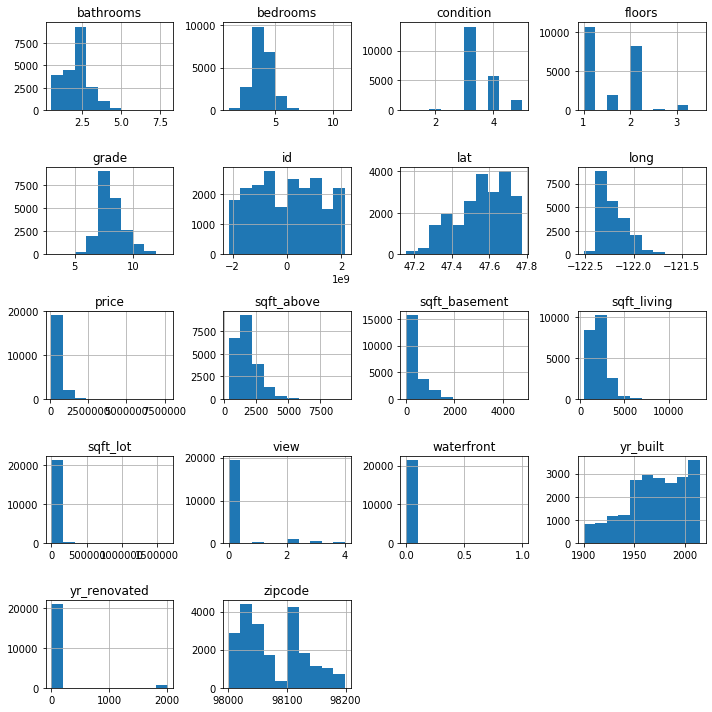

In [18]:
df_renovated.hist(figsize=(10,10))
plt.tight_layout()

## Scatter Matrix

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\misc.py:49: RuntimeWarning: overflow encountered in long_scalars
  rdelta_ext = (rmax_ - rmin_) * range_padding / 2.0


<class 'numpy.ndarray'>


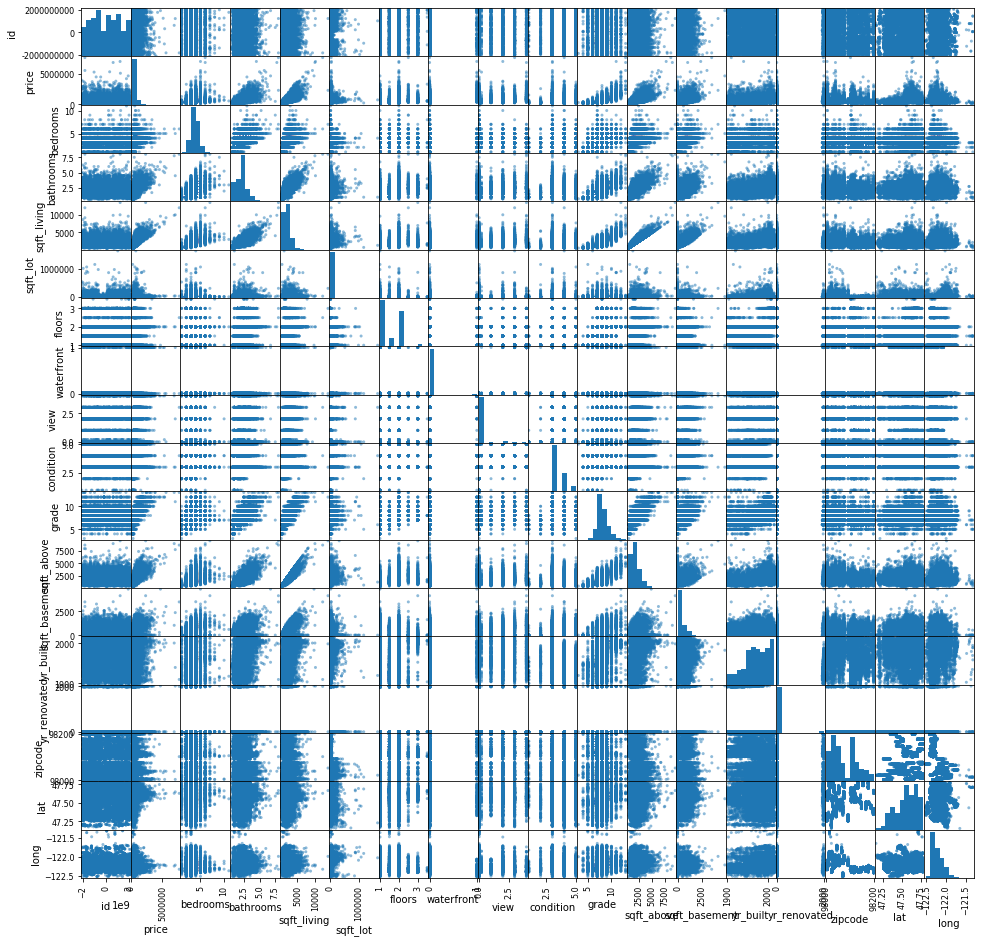

In [19]:
fig = pd.plotting.scatter_matrix(df_renovated,figsize=(16,16));
print(type(fig))

## Heatmap

Text(0.5, 1, 'Correlations')

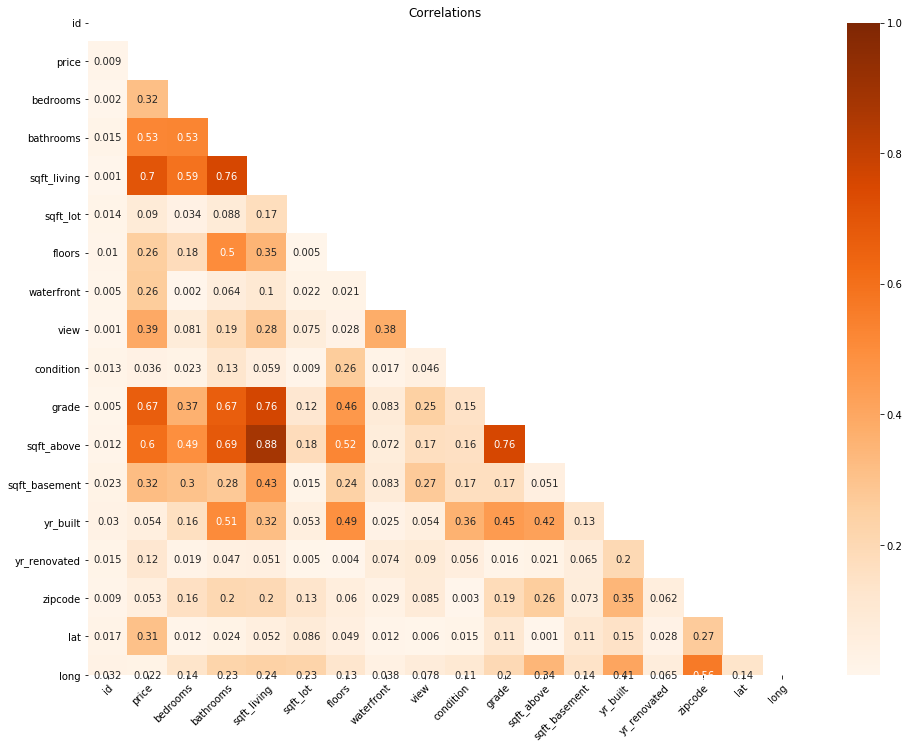

In [20]:
fig, ax = plt.subplots(figsize=(16,12))

corr = df_renovated.corr().abs().round(3)

mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, annot=True, mask=mask, cmap='Oranges', ax=ax)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Correlations')

## Scatter Target Variables (better way to do this?)

IndexError: index 10 is out of bounds for axis 0 with size 10

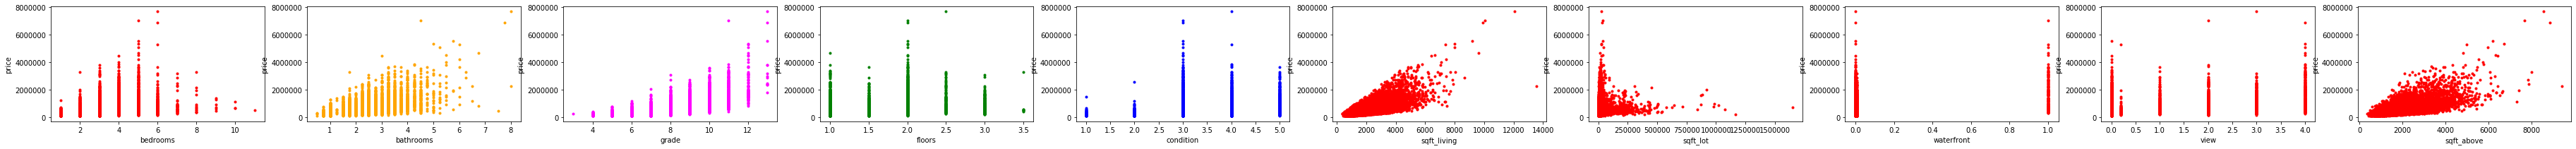

In [21]:
cols_to_plot = ["bedrooms", "bathrooms","grade","floors", "condition", "sqft_living", "sqft_lot", "waterfront", "view","sqft_above", "sqft_basement", "yr_built", "yr_renovated", "zipcode", "lat", "long", "sqft_living15", "sqft_lot15"]

colors = ['red', 'orange', 'magenta', 'green', 'blue','red','red','red','red','red','red','red','red','red','red','red','red','red']
fig, axes = plt.subplots(ncols=10, figsize=(64,3))

for i, col in enumerate(cols_to_plot):
    axes[i].scatter(x=df_renovated[col],y=df_renovated['price'],c=colors[i],marker='.')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('price')
    
plt.tight_layout()

## Plots

### Grade/Price Plot

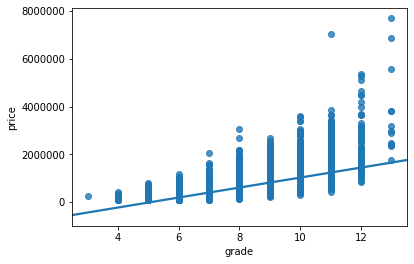

In [22]:
sns.regplot(x= 'grade', y= 'price', data=df_renovated)

### Bedrooms/Price Plot

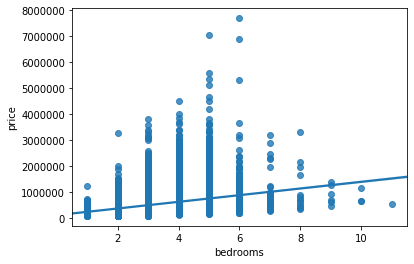

In [23]:
sns.regplot(x= 'bedrooms', y= 'price', data=df_renovated)

### Bathrooms/Price Plot

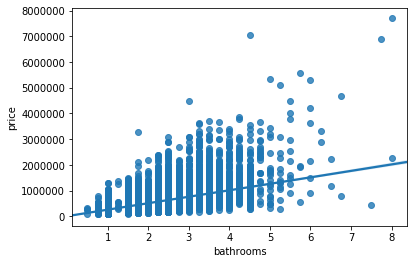

In [24]:
sns.regplot(x= 'bathrooms', y= 'price', data=df_renovated)

### Condition/Price Plot

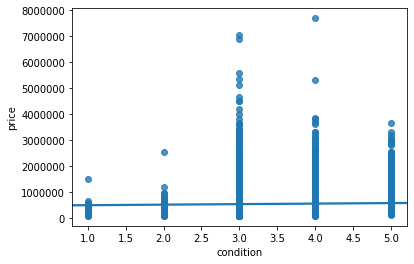

In [25]:
sns.regplot(x= 'condition', y= 'price', data=df_renovated)

### Floors/Price Plot

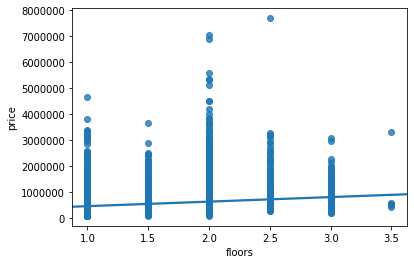

In [26]:
sns.regplot(x= 'floors', y= 'price', data=df_renovated)

### SqFt_Living/Price Plot

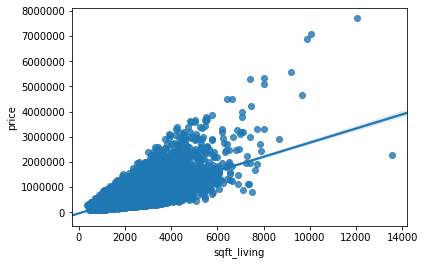

In [27]:
sns.regplot(x= 'sqft_living', y= 'price', data=df_renovated)

### SqFt_Lot/Price Plot

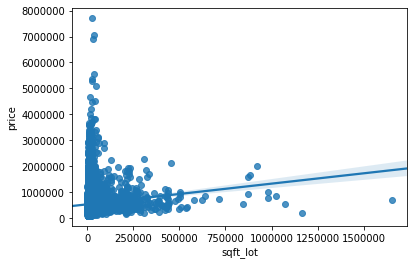

In [28]:
sns.regplot(x= 'sqft_lot', y= 'price', data=df_renovated)

### Waterfront/Price Plot (?)

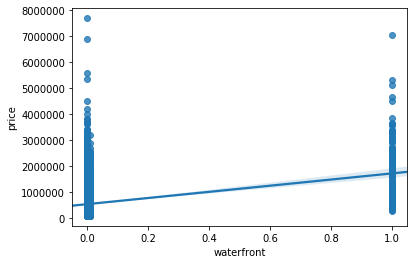

In [29]:
sns.regplot(x= 'waterfront', y= 'price', data=df_renovated)

### View/Price Plot

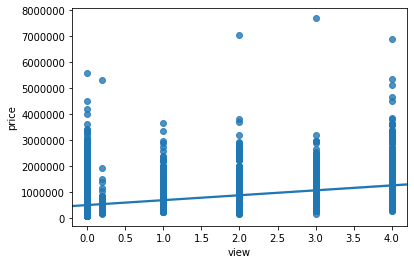

In [30]:
sns.regplot(x= 'view', y= 'price', data=df_renovated)

### SqFt_Above/Price Plot

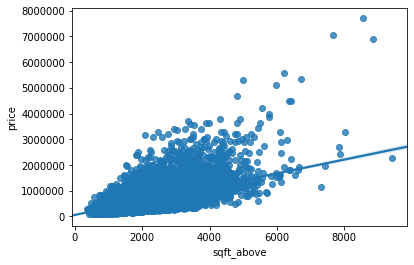

In [31]:
sns.regplot(x= 'sqft_above', y= 'price', data=df_renovated)

### SqFt_Basement/Price Plot (Needs Fixing)

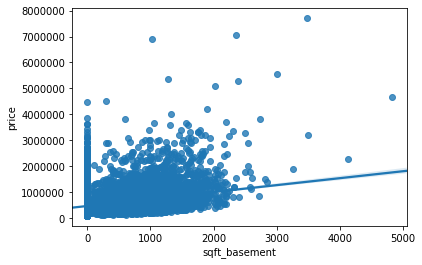

In [32]:
sns.regplot(x= 'sqft_basement', y= 'price', data=df_renovated)

### Yr_Built/Price Plot

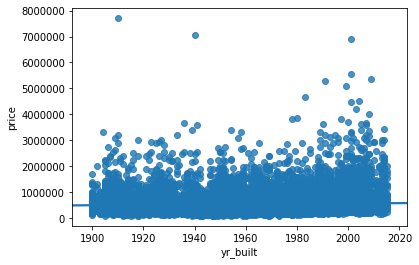

In [33]:
sns.regplot(x= 'yr_built', y= 'price', data=df_renovated)

### Yr_Renovated/Price Plot (Drop zeros/nulls)

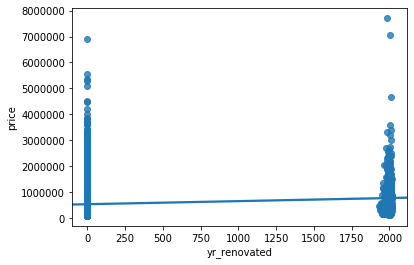

In [34]:
sns.regplot(x= 'yr_renovated', y= 'price', data=df_renovated)

### Zipcode/Price Plot (I know this isn't right)

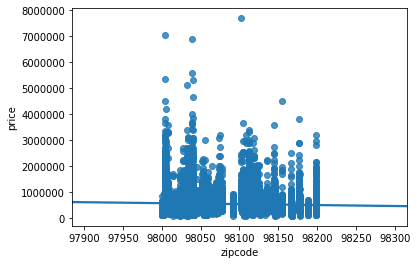

In [35]:
sns.regplot(x= 'zipcode', y= 'price', data=df_renovated)

### Lat/Price Plot

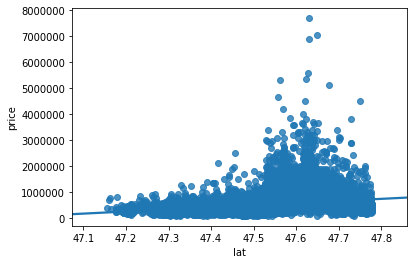

In [36]:
sns.regplot(x= 'lat', y= 'price', data=df_renovated)

### Long/Price Plot

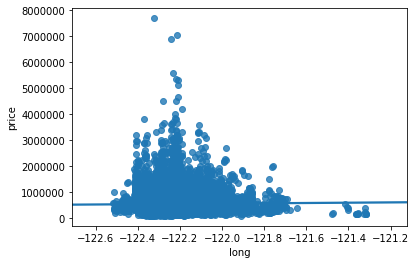

In [37]:
sns.regplot(x= 'long', y= 'price', data=df_renovated)

### SqFt_Living15/Price Plot

In [39]:
sns.regplot(x= 'sqft_living15', y= 'price', data=df_renovated)

KeyError: 'sqft_living15'

### SqFt_Lot15/Price Plot

In [40]:
sns.regplot(x= 'sqft_lot15', y= 'price', data=df_renovated)

KeyError: 'sqft_lot15'

## Dataframe Info Recheck

In [41]:
df_renovated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
id               21597 non-null int32
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int32
bathrooms        21597 non-null float64
sqft_living      21597 non-null int32
sqft_lot         21597 non-null int32
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null float64
grade            21597 non-null int32
sqft_above       21597 non-null int32
sqft_basement    21597 non-null float64
yr_built         21597 non-null int32
yr_renovated     21597 non-null int32
zipcode          21597 non-null float64
lat              21597 non-null float64
long             21597 non-null float64
dtypes: datetime64[ns](1), float64(10), int32(8)
memory usage: 2.5 MB


## Still Need Help Here

In [42]:
#Normalizing? Not Sure if Needed

#df_whatisthis = df_renovated.copy()
#df_whatisthis.columns = [col.replace(' ', '_') for col in df_whatisthis.columns]
#for col in x_cols:
#    df_whatisthis[col] = (df_whatisthis[col] - df_whatisthis[col].mean())/df_whatisthis[col].std()
#df_whatisthis.head()

# MODEL

## Initial Model on Price

In [43]:
outcome = 'price'
x_cols = ['bedrooms','bathrooms','floors','condition','grade','yr_built','yr_renovated','sqft_living', 'sqft_above','sqft_lot','waterfront','view','sqft_basement','zipcode','lat','long']

In [44]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_renovated).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     3143.
Date:                Thu, 03 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:01:23   Log-Likelihood:            -2.9440e+05
No. Observations:               21597   AIC:                         5.888e+05
Df Residuals:                   21580   BIC:                         5.890e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9.597e+06   2.88e+06      3.330      0.001    3.95e+06    1.52e+07
bedrooms      -3.889e+04   1979.328    -19.651      0.000   -4.28e+04    -3.5e+04
bathrooms      4.254e+04   3266.928     13.020      0.000    3.61e+04    4.89e+04
floors         5100.0069   3577.279      1.426      0.154   -1911.724    1.21e+04
condition      2.609e+04   2345.924     11.123      0.000    2.15e+04    3.07e+04
grade          1.004e+05   2072.648     48.429      0.000    9.63e+04    1.04e+05
yr_built      -2662.3017     71.968    -36.993      0.000   -2803.365   -2521.238
yr_renovated     22.1265      3.976      5.565      0.000      14.333      29.920
sqft_living     107.0018     18.079      5.919      0.000      71.566     142.438
sqft_above       83.6328     18.056      4.632      0.000      48.242     119.024
sqft_lot         -0.0605      0.035     -1.739      0.082      -0.129       0.008
waterfront     6.115e+05   1.82e+04     33.688      0.000    5.76e+05    6.47e+05
view           5.507e+04   2097.796     26.253      0.000     5.1e+04    5.92e+04
sqft_basement    49.9090     17.914      2.786      0.005      14.795      85.023
zipcode        -607.7351     32.870    -18.489      0.000    -672.163    -543.307
lat            6.042e+05   1.07e+04     56.309      0.000    5.83e+05    6.25e+05
long          -2.114e+05    1.3e+04    -16.316      0.000   -2.37e+05   -1.86e+05
==============================================================================
Omnibus:                    18023.033   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1702246.627
Skew:                           3.478   Prob(JB):                         0.00
Kurtosis:                      45.933   Cond. No.                     2.09e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression Results

In [45]:
model.params.sort_values()

long            -2.113663e+05
bedrooms        -3.889488e+04
yr_built        -2.662302e+03
zipcode         -6.077351e+02
sqft_lot        -6.047221e-02
yr_renovated     2.212648e+01
sqft_basement    4.990901e+01
sqft_above       8.363278e+01
sqft_living      1.070018e+02
floors           5.100007e+03
condition        2.609258e+04
bathrooms        4.253515e+04
view             5.507242e+04
grade            1.003755e+05
lat              6.041848e+05
waterfront       6.114646e+05
Intercept        9.597430e+06
dtype: float64

## Initial Trends
- Insert Here

## Refinement

### Normality

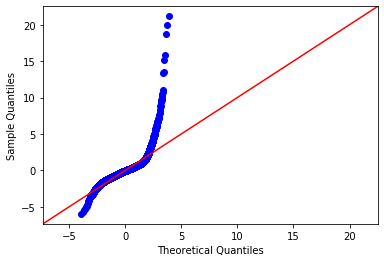

In [46]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

### Outliers Present
- Check Prices

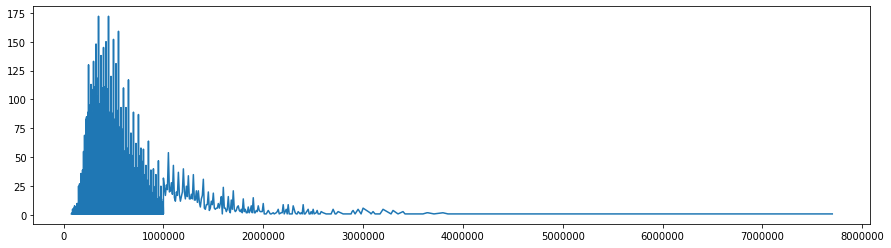

In [47]:
plt.figure(figsize=(15,4))
plt.plot(df_renovated['price'].value_counts().sort_index())

### Filter price - Attempt to Fix Normality
- Try to filter over $1,000,000

In [ ]:
for i in range(90,100):
    q = i / 100
    print('{} percentile: {}'.format(q, df_renovated['price'].quantile(q=q)))

### Homoscedasticity

In [ ]:
plt.scatter(model.predict([x_cols]), model.resid)
plt.plot(model.predict([x_cols]), [0 for i in range(len(subset))])

In [ ]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Train Split Test

In [ ]:
y = df_renovated[['price']]
X = df_renovated.drop(['price'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

In [ ]:
print(X_train)

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [ ]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [ ]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

In [ ]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

In [ ]:
linreg.score(X_test, y_test)

### Z - Score

In [59]:
z = np.abs(stats.zscore(df_renovated["price"]))
print(np.where(z > 3))

(array([   21,   153,   246,   269,   282,   300,   312,   518,   540,
         556,   656,   779,   814,  1030,  1150,  1159,  1162,  1215,
        1270,  1280,  1313,  1359,  1418,  1431,  1446,  1674,  1728,
        1730,  1768,  1942,  1943,  2038,  2083,  2134,  2138,  2177,
        2198,  2234,  2265,  2318,  2442,  2459,  2471,  2563,  2624,
        2856,  2862,  2897,  2972,  3018,  3033,  3037,  3089,  3154,
        3226,  3255,  3278,  3335,  3341,  3381,  3515,  3731,  3744,
        3757,  3765,  3773,  3809,  3857,  3867,  3910,  4009,  4028,
        4031,  4145,  4186,  4214,  4264,  4335,  4402,  4404,  4407,
        4424,  4482,  4631,  4758,  4807,  4855,  4917,  4918,  5428,
        5444,  5446,  5584,  5595,  5612,  5697,  5744,  5822,  5824,
        5858,  5874,  5961,  6035,  6039,  6189,  6191,  6227,  6329,
        6396,  6493,  6495,  6502,  6685,  6708,  6734,  6765,  6777,
        6788,  6995,  7028,  7070,  7120,  7184,  7245,  7304,  7306,
        7380,  7408

In [60]:
df_renovated

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,-1460634072,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.007596,0.0,3.0,7,1180,0.0,1955,0,98178.0,47.5112,-122.257
1,2119132896,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.000000,0.0,3.0,7,2170,400.0,1951,1991,98125.0,47.7210,-122.319
2,1336533104,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.000000,0.0,3.0,6,770,0.0,1933,0,98028.0,47.7379,-122.233
3,-1807766421,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.000000,0.0,5.0,7,1050,910.0,1965,0,98136.0,47.5208,-122.393
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.000000,0.0,3.0,8,1680,0.0,1987,0,98074.0,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.000000,0.0,3.0,8,1530,0.0,2009,0,98103.0,47.6993,-122.346
21593,-1989874472,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.000000,0.0,3.0,8,2310,0.0,2014,0,98146.0,47.5107,-122.362
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.000000,0.0,3.0,7,1020,0.0,2009,0,98144.0,47.5944,-122.299
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0.007596,0.0,3.0,8,1600,0.0,2004,0,98027.0,47.5345,-122.069


# Interpret

In [61]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     3143.
Date:                Thu, 03 Dec 2020   Prob (F-statistic):               0.00
Time:                        14:27:46   Log-Likelihood:            -2.9440e+05
No. Observations:               21597   AIC:                         5.888e+05
Df Residuals:                   21580   BIC:                         5.890e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9.597e+06   2.88e+06      3.330      0.001    3.95e+06    1.52e+07
bedrooms      -3.889e+04   1979.328    -19.651      0.000   -4.28e+04    -3.5e+04
bathrooms      4.254e+04   3266.928     13.020      0.000    3.61e+04    4.89e+04
floors         5100.0069   3577.279      1.426      0.154   -1911.724    1.21e+04
condition      2.609e+04   2345.924     11.123      0.000    2.15e+04    3.07e+04
grade          1.004e+05   2072.648     48.429      0.000    9.63e+04    1.04e+05
yr_built      -2662.3017     71.968    -36.993      0.000   -2803.365   -2521.238
yr_renovated     22.1265      3.976      5.565      0.000      14.333      29.920
sqft_living     107.0018     18.079      5.919      0.000      71.566     142.438
sqft_above       83.6328     18.056      4.632      0.000      48.242     119.024
sqft_lot         -0.0605      0.035     -1.739      0.082      -0.129       0.008
waterfront     6.115e+05   1.82e+04     33.688      0.000    5.76e+05    6.47e+05
view           5.507e+04   2097.796     26.253      0.000     5.1e+04    5.92e+04
sqft_basement    49.9090     17.914      2.786      0.005      14.795      85.023
zipcode        -607.7351     32.870    -18.489      0.000    -672.163    -543.307
lat            6.042e+05   1.07e+04     56.309      0.000    5.83e+05    6.25e+05
long          -2.114e+05    1.3e+04    -16.316      0.000   -2.37e+05   -1.86e+05
==============================================================================
Omnibus:                    18023.033   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1702246.627
Skew:                           3.478   Prob(JB):                         0.00
Kurtosis:                      45.933   Cond. No.                     2.09e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
pd.set_option('display.max_rows', None)

In [64]:
df_renovated = df_renovated.sort_values('coef', ascending=False)
df_renovated.head(15)

KeyError: 'coef'

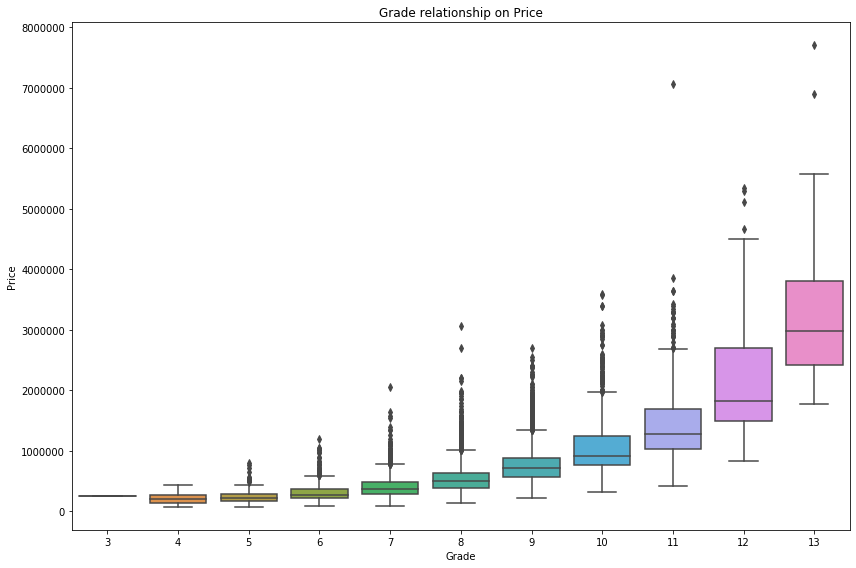

In [65]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='grade', y='price', data=df_renovated)
ax.set(title='Grade relationship on Price', 
       xlabel='Grade', ylabel='Price')

fig.tight_layout()

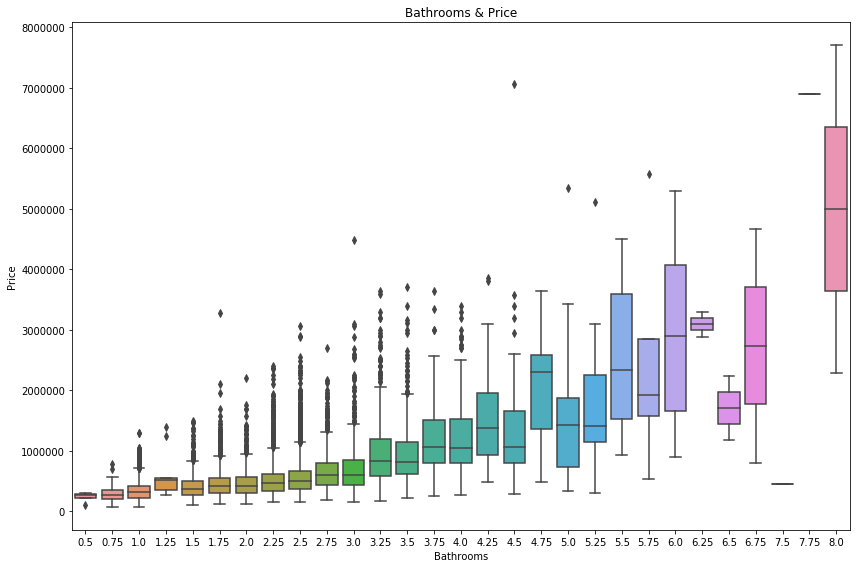

In [66]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bathrooms', y='price', data=df_renovated)
ax.set(title='Bathrooms & Price', 
       xlabel='Bathrooms', ylabel='Price')

fig.tight_layout()

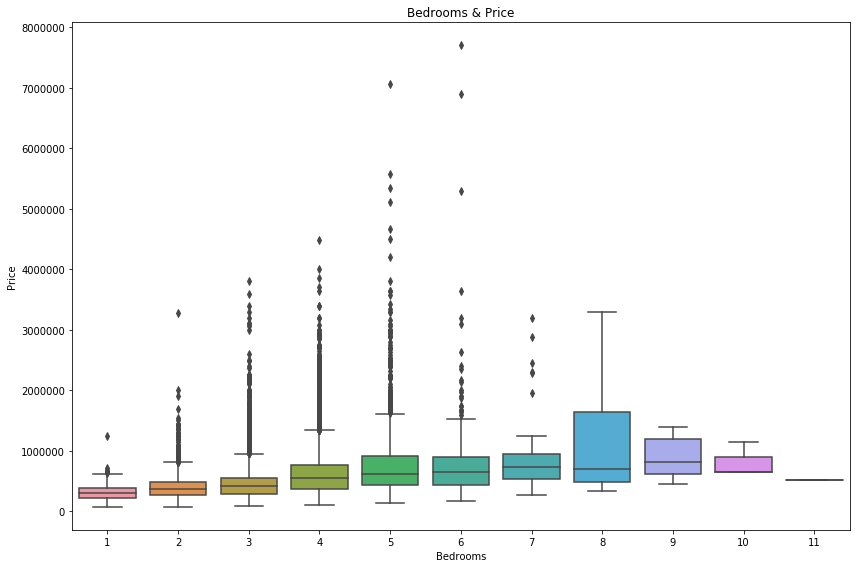

In [67]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bedrooms', y='price', data=df_renovated)
ax.set(title='Bedrooms & Price', 
       xlabel='Bedrooms', ylabel='Price')

fig.tight_layout()

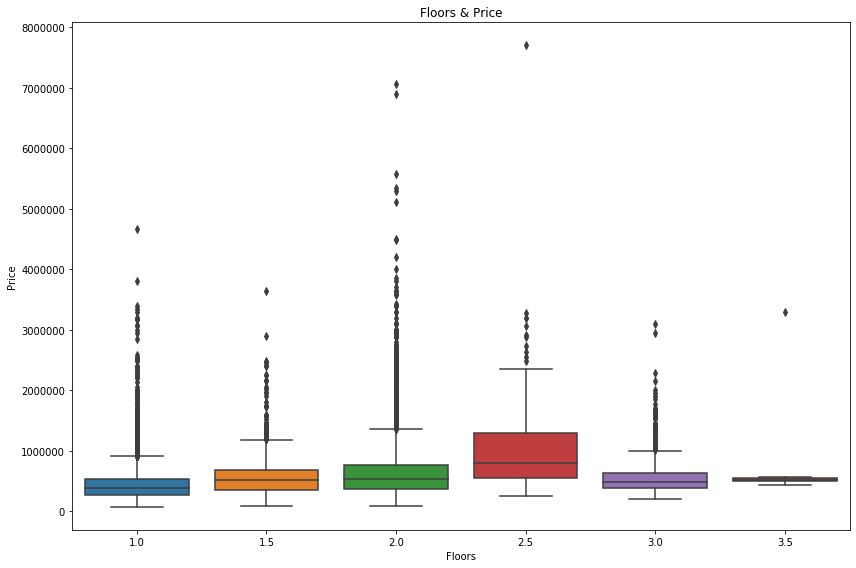

In [68]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='floors', y='price', data=df_renovated)
ax.set(title='Floors & Price', 
       xlabel='Floors', ylabel='Price')

fig.tight_layout()

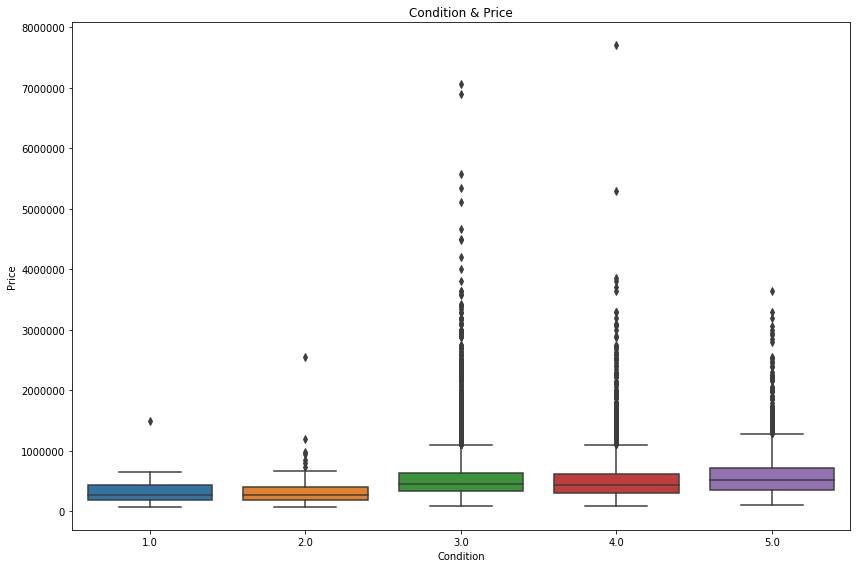

In [69]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='condition', y='price', data=df_renovated)
ax.set(title='Condition & Price', 
       xlabel='Condition', ylabel='Price')

fig.tight_layout()

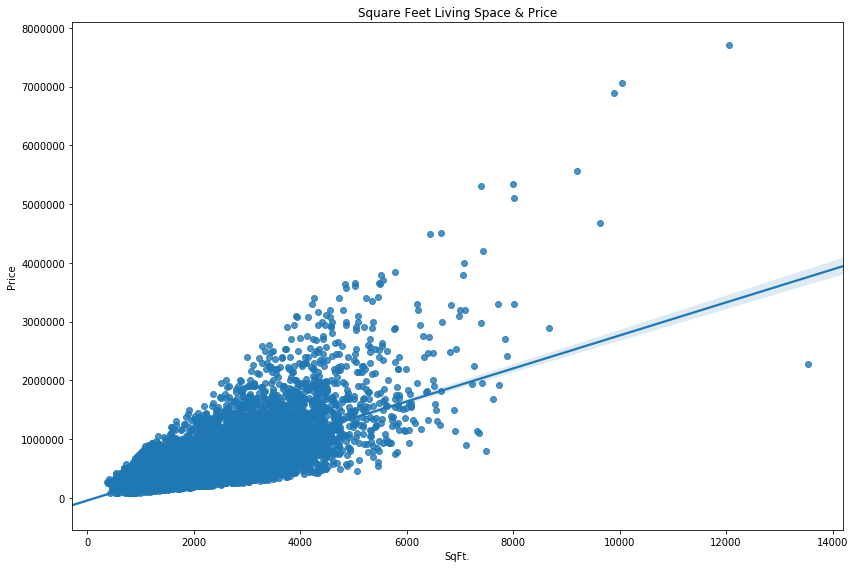

In [70]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_living', y='price', data=df_renovated)
ax.set(title='Square Feet Living Space & Price', 
       xlabel='SqFt.', ylabel='Price')

fig.tight_layout()

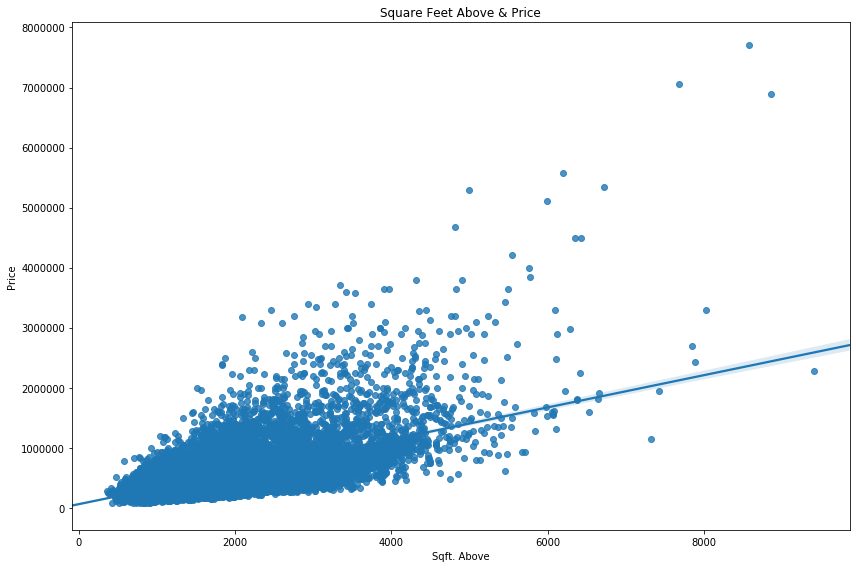

In [71]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_above', y='price', data=df_renovated)
ax.set(title='Square Feet Above & Price', 
       xlabel='Sqft. Above', ylabel='Price')

fig.tight_layout()

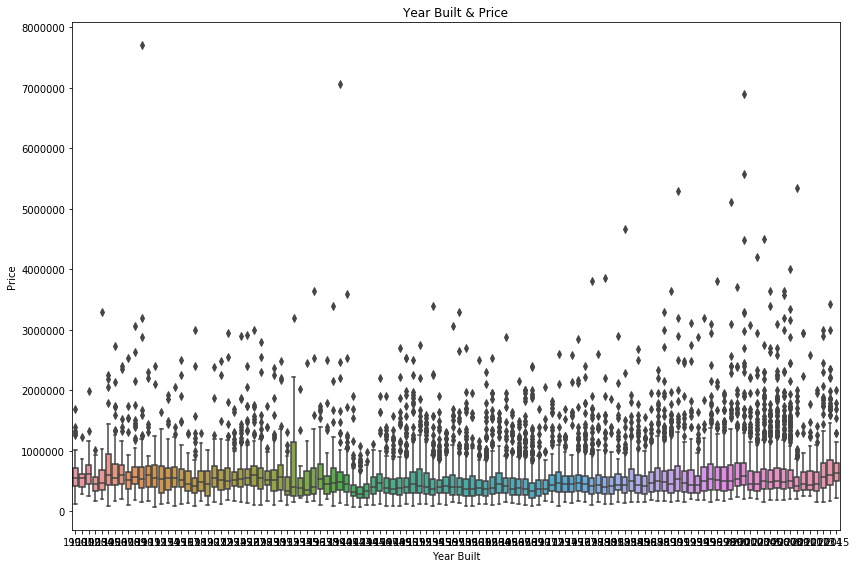

In [72]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_built', y='price', data=df_renovated)
ax.set(title='Year Built & Price', 
       xlabel='Year Built', ylabel='Price')

fig.tight_layout()

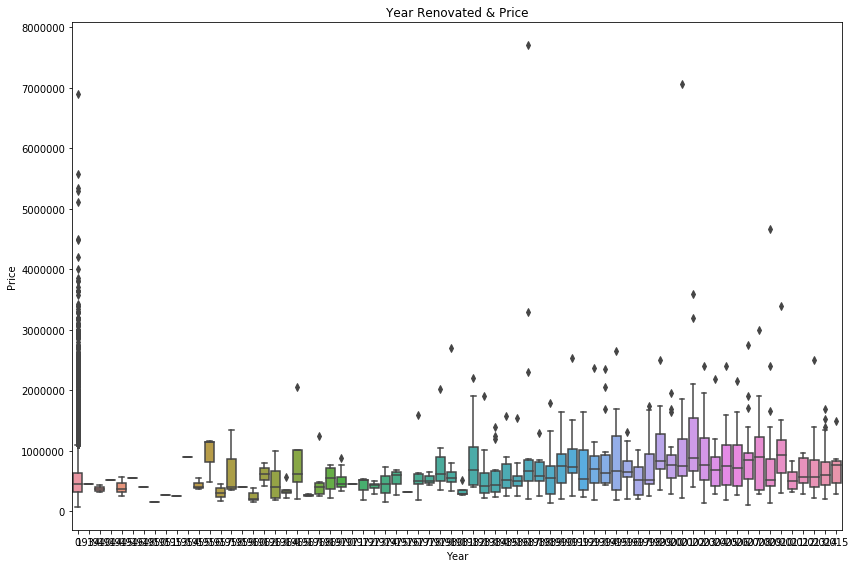

In [73]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_renovated', y='price', data=df_renovated)
ax.set(title='Year Renovated & Price', 
       xlabel='Year', ylabel='Price')

fig.tight_layout()

# Conclusions & Recommendations